In [ ]:
# Copyright (C) 2016-2018 by Jakob J. Kolb at Potsdam Institute for Climate
# Impact Research
#
# Contact: kolb@pik-potsdam.de
# License: GNU AGPL Version 3
%matplotlib inline
import PyDSTool as pdt
import numpy as np
import networkx as nx
from random import shuffle
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from pydivest.macro_model.integrate_equations_aggregate import IntegrateEquationsAggregate as Model


In [ ]:
# investment_decisions:

nopinions = [50, 50]

# Parameters:

phi, b_d = 0.5, 3.

input_parameters = {'b_c': 1., 'phi': .0, 'tau': 1.,
                    'eps': 0.01, 'b_d': 4., 'e': 1.,
                    'b_r0': 0.1,
                    'possible_cue_orders': [[0], [1]],
                    'xi': .12, 'd_k': 0.06, 'd_c': 0.1, 'kappa_c': 0.5,
                    'L': 100., 'C': 1., 'G_0': 500000.,
                    'campaign': False, 'learning': True,
                    'interaction': 1, 'test': False,
                    'R_depletion': True}

# investment_decisions
opinions = []
for i, n in enumerate(nopinions):
    opinions.append(np.full((n), i, dtype='I'))
opinions = [item for sublist in opinions for item in sublist]
shuffle(opinions)

# network:
N = sum(nopinions)
p = .2

while True:
    net = nx.erdos_renyi_graph(N, p)
    if len(list(net)) > 1:
        break
adjacency_matrix = nx.adj_matrix(net).toarray()

# investment
clean_investment = np.ones(N)
dirty_investment = np.ones(N)

init_conditions = (adjacency_matrix, opinions,
                   clean_investment, dirty_investment)
m = Model(*init_conditions, **input_parameters)

In [ ]:
DSargs = pdt.args(name='aggregated_approximation')
v_e, v_pi, v_tau = sp.symbols('v_e v_pi v_tau')
v_K_cc, v_K_cd, v_K_dc, v_K_dd = sp.symbols('K_cc K_cd K_dc K_dd')
v_subs = {m.e: v_e, m.pi: v_pi, m.tau: v_tau,
          m.Kcc: v_K_cc, m.Kcd: v_K_cd, 
          m.Kdc: v_K_dc, m.Kdd: v_K_dd}

equations = {m.var_symbols[i]: str(m.rhs_raw[i].subs(v_subs)) for i in range(len(m.var_names))}

equations_updated = {}
for (symbol, value) in equations.items():
    if symbol in v_subs.keys():
        equations_updated[str(v_subs[symbol])] = value
    else:
        equations_updated[str(symbol)] = value
        


params_updated = {}
for (symbol, value) in m.list_parameters().items():
    if symbol in v_subs.keys():
        params_updated[str(v_subs[symbol])] = value
    else:
        params_updated[str(symbol)] = value



initial_conditions = {}
for (symbol, value) in m.list_initial_conditions().items():
    if symbol in v_subs.keys():
        initial_conditions[str(v_subs[symbol])] = value
    else:
        initial_conditions[str(symbol)] = value   
    

del equations_updated['G']
del initial_conditions['G']

# params_updated['G'] = m.p_G_0
# params_updated['xi'] = 0.12
# params_updated['delta_c'] = 0.1

params_updated['G'] = m.p_G_0
params_updated['xi'] = 0.133
params_updated['phi'] = .8
params_updated['delta_c'] = 0.1

initial_conditions['C'] = 4#0000
initial_conditions['K_cc'] = 5#000
initial_conditions['K_dd'] = 10000

print(params_updated)

DSargs.pars = params_updated
DSargs.varspecs = equations_updated
DSargs.ics = initial_conditions
DSargs.pdomain = {'xi':[0.1, 0.15], 'b_d': [1., 4.]}
DSargs.tdata = [0, 300]
DSargs.algparams = {'init_step': 0.2}

In [ ]:
ode = pdt.Generator.Vode_ODEsystem(DSargs)
traj = ode.compute('trajectory to initial conditions')
pts = traj.sample(dt=1.)

In [ ]:
fig, axes = plt.subplots(ncols=2)
fig.set_figwidth(10)
axes[0].plot(pts['t'], pts['K_cc'], label='$K_c^c$')
axes[0].plot(pts['t'], pts['K_cd'], label='$K_c^d$')
axes[0].plot(pts['t'], pts['K_dc'], label='$K_d^c$')
axes[0].plot(pts['t'], pts['K_dd'], label='$K_d^d$')
axes[0].plot(pts['t'], pts['C'], label='C')
axes[0].legend()

axes[1].plot(pts['t'], pts['x'], label='x')
axes[1].plot(pts['t'], pts['y'], label='y')
axes[1].plot(pts['t'], pts['z'], label='z')
axes[1].legend()



In [ ]:
ode.set(ics=pts[-1])

In [ ]:
PC = pdt.ContClass(ode)
PCargs = pdt.args(name='EQ1', type='EP-C')
PCargs.freepars = ['xi']
PCargs.MaxNumPoints = 200
PCargs.MaxStepSize = 2
PCargs.MinStepSize = 1e-2
PCargs.StepSize = 1e-1
PCargs.verbosity = 1
PCargs.SaveEigen = True
# PCargs.LocBifPoints = ['LP', 'B']
PCargs.LocBifPoints = 'all'
PCargs.StopAtPoints = ['B']

In [ ]:
PC.newCurve(PCargs)

In [ ]:
import time

start = time.clock()
PC['EQ1'].forward()
stop = time.clock()
print(stop-start)

107.072273


In [ ]:
%matplotlib inline
fig, axes = plt.subplots(ncols=4)
PC['EQ1'].display(coords=('xi', 'C'), axes=(2, 2, 1), stability=True)
PC['EQ1'].display(coords=('xi', 'K_dc'), axes=(2, 2, 2), stability=True)
PC['EQ1'].display(coords=('xi', 'x'), axes=(2, 2, 3), stability=True)
PC['EQ1'].display(coords=('xi', 'z'), axes=(2, 2, 4), stability=True)
PC['EQ1'].plot.togglePoint('LP1')
fig = plt.gcf()
fig.set_figwidth(8)
fig.set_figheight(8)
for ax, title in zip(fig.get_axes(), ['C', r'$K_d^c$', 'x', 'z']):
    ax.set_title('')
    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel(title)
fig.tight_layout()

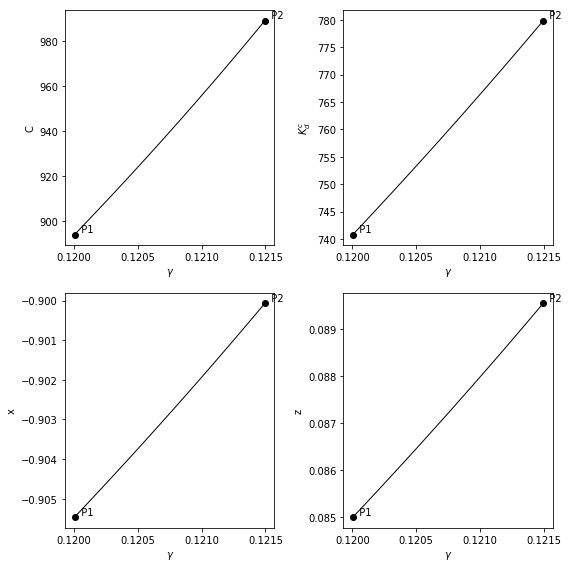

In [ ]:
#PC['EQ1'].plot.togglePoints(visible='off', byname=['LP1', 'LP2', 'P2', 'P1'])
PC['EQ1'].plot.toggleLabels(visible='off', byname=['LP3', 'LP4', 'B', 'B1'])
PC['EQ1'].plot.refresh()
PC['EQ1'].plot.fig1.fig.savefig('ba_plot.pdf')
PC['EQ1'].plot.fig1.fig